In [1]:
import os
import uuid
import base64
from IPython import display
from unstructured.partition.pdf import partition_pdf
# from langchain.chat_models import ChatOpenAI
from langchain_community.chat_models import ChatOllama
from langchain_community import embeddings

# from langchain.embeddings import OpenAIEmbeddings
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
from langchain.schema.messages import HumanMessage, SystemMessage
from langchain.schema.document import Document
from langchain.vectorstores import FAISS
from langchain.retrievers.multi_vector import MultiVectorRetriever

In [2]:
output_path = "./final_ppt_images_update"

In [3]:
image_elements = []

def encode_image(image_path):
    with open(image_path, "rb") as f:
        return base64.b64encode(f.read()).decode('utf-8')
for i in os.listdir(output_path):
    if i.endswith(('.png', '.jpg', '.jpeg')):
        image_path = os.path.join(output_path, i)
        encoded_image = encode_image(image_path)
        image_elements.append(encoded_image)

In [4]:
len(image_elements)

150

In [5]:
image_elements[0]

'iVBORw0KGgoAAAANSUhEUgAABOQAAAKfCAYAAADO9BckAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAADsMAAA7DAcdvqGQAAP+lSURBVHhe7J0HgBXF/cd/V+gcvXdQehMRRKxYsWA3GmtM+VvS1BiTWBJNbDGWaKyJvTdsWLAiFoqICNJBeu9wwFXu/u+7b+fevLnZ9/bVe+/u+9Hl7e5tnflN++5vZnL+9dDUymuvHCWEEEIIIYQQQgghhJDUkzuwbxt3lRBCCCGEEEIIIYQQkmpy+/WmIEcIIYQQQgghhBBCSLrIKSvbV5mfn+tuEkIIIYQQQgghhBBCUklOZQB3nRBCCCGEEEIIIYQQkmLoGkcIIYQQQgghhBBCSBqhIEcIIYQQQgghhBBCSBqhIEcIIYQQQgghhBBCSBqhIEcIIYQQQgghhBBCSBqJe1KHFVt2S8/r3nC3qvOnkwbJnWcf6G4RIvKb56fLQ58tcreC/ProvvLghQe7W9lDzs+fdddCVD55sbtGspmD//G+fLN8i7sV5LlfHSYXHtLL3cpM4k1fU3/cLFe9OEOm33SSu4fUJm5/9wf5dMF6mbF8qxQWlzn7ChrWk/4dm0u/wHLL6UOlR5umzn4SO7WpXCOZBerZf3trthw3sKO1/Hl+6jK56H9fuVtBRvZsk9V5ebaVv37joKbyiVTaSG2rBzMvJyR+/vz6d85vXdN+UE4/+vlimbRgQ1jZ1alFY+nSsrGM6d/BV5jE7SH34rTl7pqdt75b5a4RQgjJNFCIoAI6+rYPqjWASO0Ajdsb3pglnwUqCkqMA1hHnD875UeKcYRkIBDSh/x1gpNGCSGEkEwEon+/69+Sf74/V3Zr9cy6ABwaDr19ovPuZjtq3Y69zj4IdX6IW5CLVklYtGGX86CEEEIyiwc/XegUIubXYFJ7wNfKaEIrvuARQjKHd2evqRLSdRGdEEIIyRTwUf+MByc5Hrj

In [5]:
len(image_elements[0])

178064

In [6]:
import os
import ollama
from tqdm import tqdm
import base64
from PIL import Image
from io import BytesIO
from langchain.text_splitter import CharacterTextSplitter


In [7]:
img_summaries = []

# Iterate over all image strings in the list with a tqdm progress bar
for image_string in tqdm(image_elements, desc="Processing images"):
    # Decode the image string using utf-8 encoders
    img_data = base64.b64decode(image_string)
    img = Image.open(BytesIO(img_data))
    
    # Convert the image to RGB
    img_rgb = img.convert('RGB')
    
    # Save the image to a temporary file
    img_rgb.save("temp.jpg")
    
    # Call the chat function with the image file
    res = ollama.chat(
        model="llava",
        messages=[
            {
                'role':'user',
                'content':'I will be providing an image that pertains to focusing on multiple sclerosis. This image could take the form of a graph, chart, or any other visual representation. Your task is to meticulously analyze the image, extract all text labels present, and comprehend the image in depth. Subsequently, provide a comprehensive description of the image using appropriate medical terminology.',
                'images':["temp.jpg"]
            }
        ]
    )
    # I am going to provide an image related to the medical field, specifically multiple sclerosis. The image could be a graph, chart, or any other form of visual representation. Please extract the text labels from the image, understand the image deeply, and provide a detailed description of the image in medical terms.
    # Append the result to the image_summary list
    img_summaries.append(res['message']['content'])

print(img_summaries)
documents = []
retrieve_contents = []
for e, s in zip(image_elements, img_summaries):
    doc = Document(
        page_content = s,
        metadata = {
            'id': i,
            'type': 'image',
            'original_content': e
        }
    )
    retrieve_contents.append((i, s))
    documents.append(doc)

vectorstore = FAISS.from_documents(documents=documents, embedding=embeddings.OllamaEmbeddings(model='nomic-embed-text'))
vectorstore.save_local("final_ppt_images_faiss_up")


from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter_rec = RecursiveCharacterTextSplitter(
    chunk_size = 1000,
    chunk_overlap  = 0,
    length_function = len,
    is_separator_regex=False
)
texts_rec = text_splitter_rec.split_documents(documents)
rec_vectorstore = FAISS.from_documents(documents=texts_rec, embedding=embeddings.OllamaEmbeddings(model='nomic-embed-text'))
rec_vectorstore.save_local("final_ppt_images_faiss_rec_updated")


# text_splitter = CharacterTextSplitter.from_tiktoken_encoder(chunk_size=1000, chunk_overlap=100)

# doc_splits = text_splitter.split_documents(documents)
# char_vectorstore = FAISS.from_documents(documents=doc_splits, embedding=embeddings.OllamaEmbeddings(model='nomic-embed-text'))
# char_vectorstore.save_local("final_ppt_images_faiss_char")


Processing images:   0%|          | 0/150 [00:00<?, ?it/s]

Processing images: 100%|██████████| 150/150 [3:01:23<00:00, 72.55s/it]  


[' The image you\'ve provided appears to be a slide from a presentation related to multiple sclerosis (MS). It includes text and graphical elements, but the quality of the image is quite low, making it difficult to read some details. Nevertheless, I can attempt to describe what can be discerned:\n\n1. **Title and Subtitle**: The slide has a title that seems to be related to "focusing on multiple sclerosis," possibly discussing a study or approach to treating MS with ocrelizumab (OCRELZUMAB), an FDA-approved drug for the treatment of relapsing forms of MS.\n\n2. **Data Visualization**: There\'s a bar chart that compares the efficacy of different treatments (OCRELZUMAB, PONVSITID, TREATMENT) across multiple weeks (12-14). The chart shows numerical values for each treatment and week combination, but the numbers are not legible due to the image quality.\n\n3. **Percentage Values**: There is a bar graph with percentage values, presumably showing the efficacy of different treatments over tim

In [8]:
vectorstore = FAISS.from_documents(documents=documents, embedding=embeddings.OllamaEmbeddings(model='nomic-embed-text'))
vectorstore.save_local("new")

In [4]:
# embedding = embeddings.OllamaEmbeddings(model='nomic-embed-text')

db1 = FAISS.load_local("rec_ppt_images_MS_final", embeddings=embeddings,allow_dangerous_deserialization=True)
db2 = FAISS.load_local("4_ex_rec_ppt_images_MS_final", embeddings=embeddings,allow_dangerous_deserialization=True)
db1.merge_from(db2)
db1.save_local("new_multiple_sclerosis_ppt_faiss")


In [6]:
embeddings = embeddings.OllamaEmbeddings(model='nomic-embed-text')

In [9]:
# db = FAISS.load_local("new_multiple_sclerosis_ppt_faiss", embeddings,allow_dangerous_deserialization=True)

In [16]:
db = FAISS.load_local("final_ppt_images_faiss_rec_updated", embeddings,allow_dangerous_deserialization=True)
# db = FAISS.load_local("final_ppt_images_faiss_up", embeddings,allow_dangerous_deserialization=True)

In [17]:
prompt_template = """
You are a data scientist and an expert in analyzing images and tables and text.
Answer the question based only on the following context, which can include text, images and tables:
{context}
Question: {question}
Don't answer if you are not sure and decline to answer and say "Sorry, I don't have much information about it."
Just return the helpful answer in as much as detailed possible.
Answer:
"""

In [18]:
qa_chain = LLMChain(llm=ChatOllama(model="mistral", temperature=0),
                        prompt=PromptTemplate.from_template(prompt_template))

In [19]:
db.similarity_search("what are the common symtoms of MS")

[Document(page_content='1. "Neurological mechanisms of MS."\n2. "Symptoms that can manifest in number of ways?"\n3. "Acute symptoms (that may resolve spontaneously)."\n4. "Chronic symptoms."\n5. "Relapses with acute symptoms."\n6. "Symptoms with progression of disease."\n7. "Symptoms with underlying disability and chronic pain."\n8. "Neurological manifestations of MS."\n9. "Clinical manifestations."\n10. "Symptoms (that may be permanent)."\n\nThe specific details of the symptoms and mechanisms are not entirely clear due to the angle of the image, but they seem to be arranged in a circular pattern with arrows pointing outward from the central hub to indicate different stages or aspects of MS. The overall impression is that of an educational tool designed to explain the complexity of MS symptoms and their underlying biological processes.', metadata={'id': 'img(99).png', 'type': 'image', 'original_content': 'iVBORw0KGgoAAAANSUhEUgAABCkAAAJzCAYAAAAiM0nMAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8Y

In [20]:

# def answer(question):
#     relevant_docs = db.similarity_search(question)
#     context = ""
#     relevant_images = []
#     for d in relevant_docs:
#         if d.metadata['type'] == 'text':
#             context += '[text]' + d.metadata['original_content']
#         elif d.metadata['type'] == 'table':
#             context += '[table]' + d.metadata['original_content']
#         elif d.metadata['type'] == 'image':
#             context += '[image]' + d.page_content
#             relevant_images.append(d.metadata['original_content'])
#     result = qa_chain.run({'context': context, 'question': question})
#     return result, relevant_images

def answer(question):
    relevant_docs = db.similarity_search(question)
    # context = ""
    relevant_images = []
    for d in relevant_docs:
        # if d.metadata['type'] == 'text':
        #     context += '[text]' + d.metadata['original_content']
        # elif d.metadata['type'] == 'table':
        #     context += '[table]' + d.metadata['original_content']
        if d.metadata['type'] == 'image':
            # context += '[image]' + d.page_content
            relevant_images.append(d.metadata['original_content'])
    # result = qa_chain.run({'context': context, 'question': question})
    return relevant_images

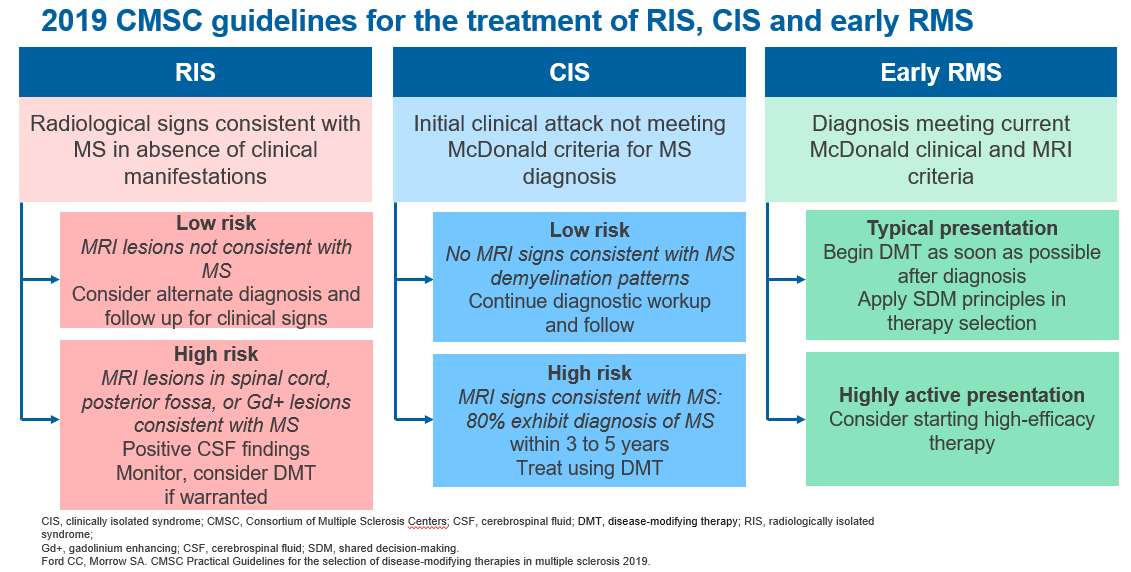

In [23]:
relevant_images = answer("what is the treatment for relapcing onset ms with active phenotype")
display.display(display.Image(base64.b64decode(relevant_images[0])))

In [16]:
result, relevant_images = answer("symptoms of multiple sclerosis?")
print(result)

c:\Users\RAHUL\Desktop\chatbot_new\chatbot\multimodel\Lib\site-packages\langchain_core\_api\deprecation.py:117: LangChainDeprecationWarning: The function `run` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


 Multiple Sclerosis (MS) is a chronic disease that affects the central nervous system, leading to various symptoms that can impact an individual's health and quality of life. The symptoms of MS are unpredictable and can manifest in numerous ways. Some common symptoms include:

1. Fatigue: This is one of the most prevalent symptoms of MS, affecting up to 90% of individuals with the condition. It can range from feeling tired after physical activity to experiencing extreme exhaustion that limits daily activities.
2. Sensory problems: These issues may involve visual, auditory, or tactile impairments. For example, vision problems like blurred vision, double vision, or optic neuritis can occur. Auditory symptoms might include hearing loss or ringing in the ears (tinnitus). Tactile symptoms could include numbness, tingling, or sensitivity to touch.
3. Movement impairment: MS can affect motor control and coordination, leading to difficulties with balance, walking, and fine motor skills. This i

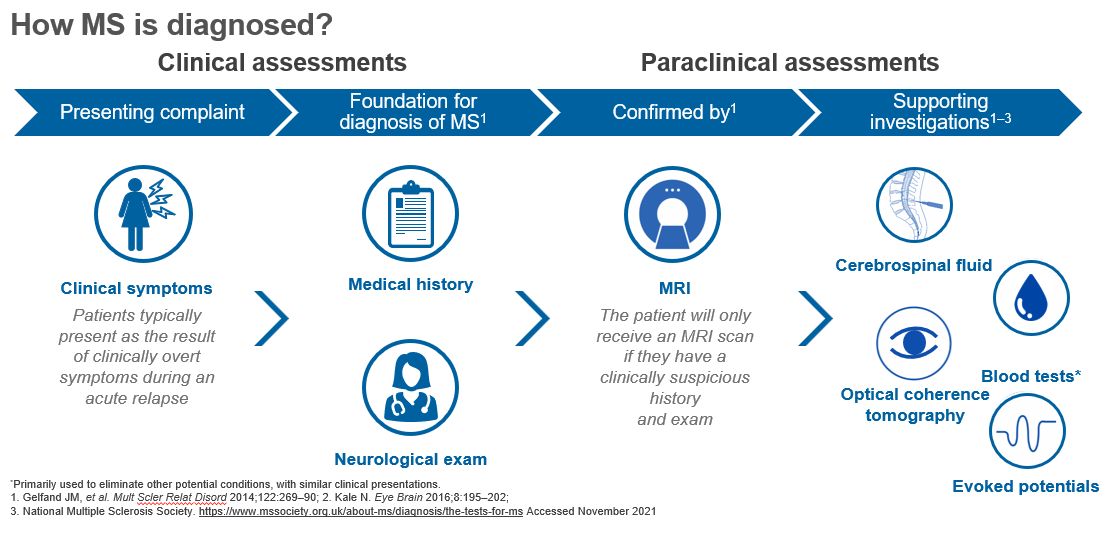

In [19]:
display.display(display.Image(base64.b64decode(relevant_images[0])))

In [14]:
result, relevant_images = answer("symptoms of multiple sclerosis?")
print(result)

c:\Users\RAHUL\Desktop\chatbot_new\chatbot\multimodel\Lib\site-packages\langchain_core\_api\deprecation.py:117: LangChainDeprecationWarning: The function `run` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


 Multiple sclerosis (MS) is a chronic condition that affects the central nervous system, leading to various symptoms. The infographic you provided categorizes these symptoms into common, lesser common, and rare categories.

**Common Symptoms:**
1. Fatigue: Feeling tired or worn out, which can impact day-to-day activities.
2. Muscle stiffness and spasms: Causing muscles to feel stiff and tight, leading to painful spasms.
3. Numbness or paresthesia: A feeling of numbness or tingling in the skin, often on the hands and feet, due to nerve damage.
4. Vision problems: MS can cause vision issues such as blurred vision, double vision (diplopia), or temporary blindness in an eye.
5. Pain: Ranging from mild discomfort to severe pain.
6. Bladder and bowel symptoms: MS can cause problems with the bladder and bowel, such as frequency of urination or constipation.

**Lesser Common Symptoms:**
1. Problems with coordination and balance: Difficulty walking, tripping, or falling due to a lack of coordin

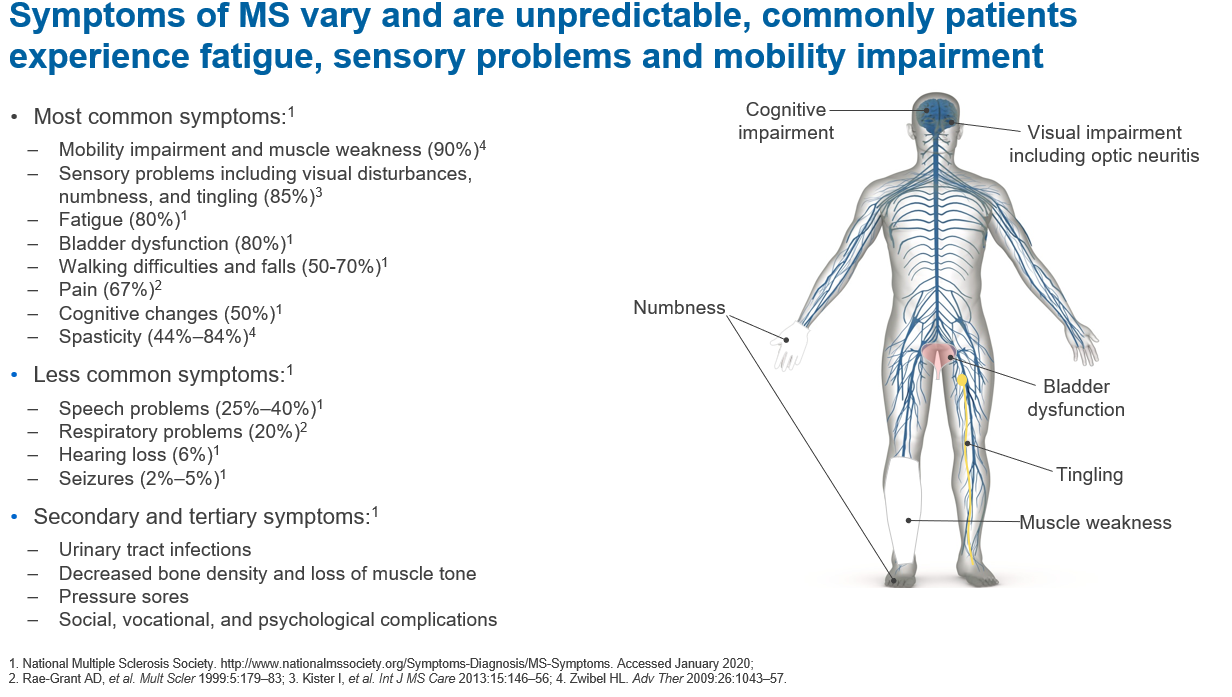

In [15]:
display.display(display.Image(base64.b64decode(relevant_images[0])))

In [8]:
result, relevant_images = answer("symptoms of multiple sclerosis?")
print(result)

c:\Users\Barani\Desktop\chatbot\multimodel\Lib\site-packages\langchain_core\_api\deprecation.py:119: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


 Multiple Sclerosis (MS) is an autoimmune disease that affects the central nervous system, leading to various symptoms. The common symptoms of MS include:

1. Fatigue: Extreme tiredness, both physical and mental.
2. Muscle weakness: Difficulty moving muscles or maintaining a position.
3. Numbness/tingling: Sensations of pins and needles or loss of feeling in different parts of the body.
4. Balance problems and coordination difficulties: Issues with maintaining balance, walking, and performing fine motor tasks.
5. Muscle spasms: Involuntary muscle contractions.
6. Nerve pain: Pain caused by damage to nerves.
7. Vision changes: Optic neuritis or other vision disturbances.
8. Dizziness or vertigo: Feeling lightheaded, unsteady, or experiencing spinning sensations.

Secondary symptoms of MS can include:

1. Visual disturbances: Double vision, blurred vision, or other visual problems.
2. Urinary issues: Frequent urination, incontinence, or difficulty emptying the bladder.
3. Constipation: D

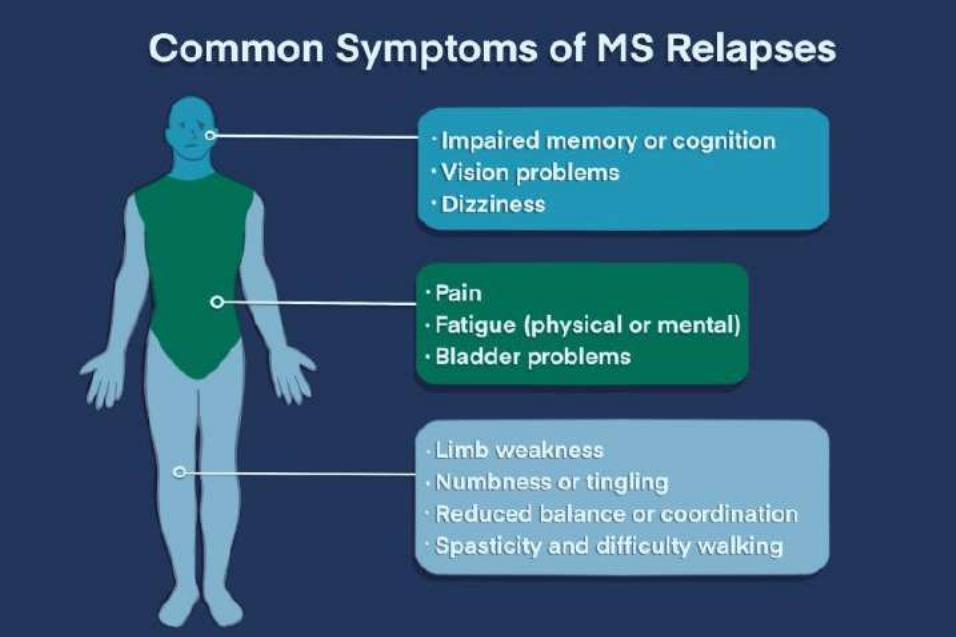

In [9]:
display.display(display.Image(base64.b64decode(relevant_images[0])))

In [16]:
result, relevant_images = answer("what is an escalation therapy?")
print(result)

 An escalation therapy refers to a treatment strategy where a patient with multiple sclerosis (MS) is transitioned from one disease-modifying therapy (DMT) to another, more aggressive DMT if their current treatment is not effective or if they show signs of worsening. The rationale behind this approach is to manage the disease more effectively and potentially reverse the progression of disability caused by MS.

The image provided illustrates an escalation pathway with four levels, each representing increased disease activity or severity. The reasons for escalating therapy include things like "Not enough improvement," "Aggressive MRI," "Progression of disability," "Negative MRI," and "Higher EDSS score." The treatments associated with these reasons are various DMTs.

It's important to note that the rapid escalation of therapy could potentially lead to aggressive therapies being used without clear evidence of efficacy or safety, as emphasized by a cautionary note in the image. Therefore, 

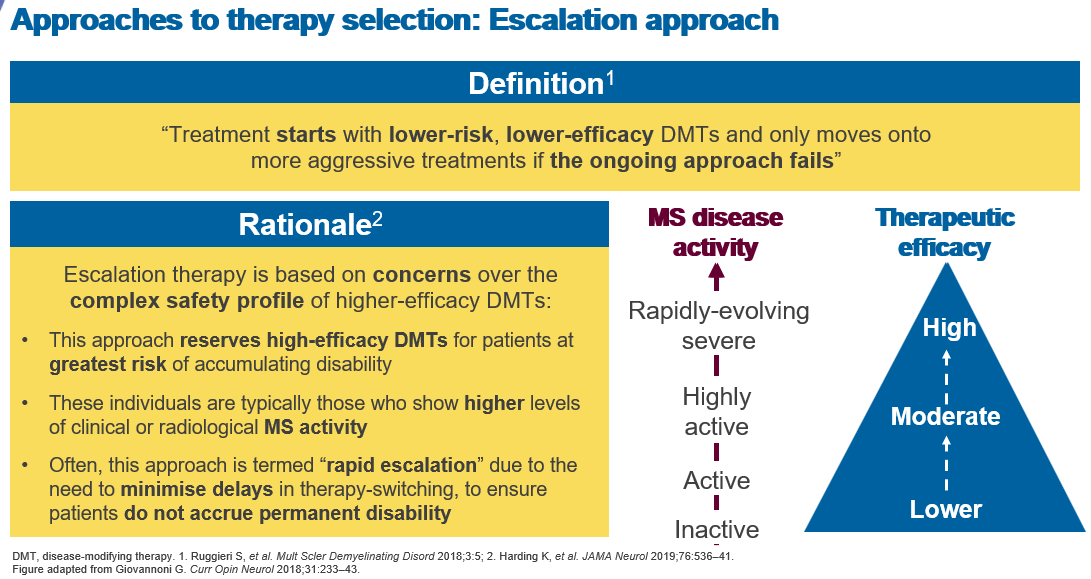

In [17]:
display.display(display.Image(base64.b64decode(relevant_images[0])))

In [10]:
result, relevant_images = answer("what is an escalation therapy?")
print(result)

 An escalation therapy is a treatment strategy in multiple sclerosis (MS) where patients start with less aggressive therapies and then gradually progress to more potent treatments based on the complexity of their disease and the need for more effective interventions. The rationale behind this approach is to minimize potential negative effects, such as increased risk of severe adverse events or rapid progression, by starting with lower risk treatments. As the disease progresses or becomes more complex, patients may move onto more aggressive therapies to address the increasing symptoms and disability. This approach allows for a personalized treatment plan tailored to each patient's unique needs and disease course. However, it is essential to consider various factors like patient age, disease severity, presence of comorbid conditions, effectiveness, safety, and tolerability when selecting therapies for MS patients.


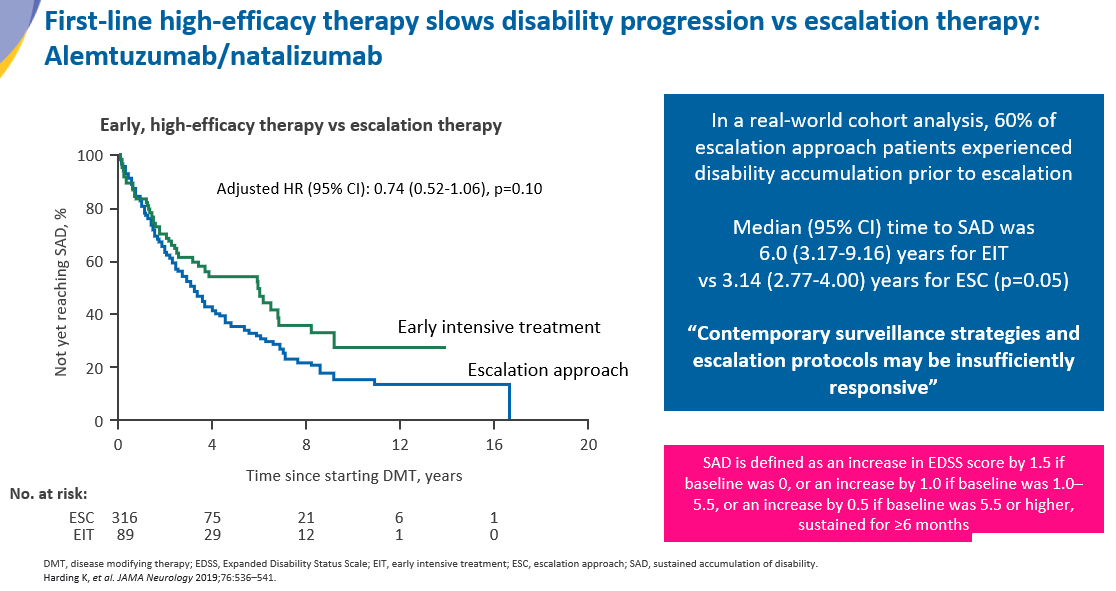

In [11]:
display.display(display.Image(base64.b64decode(relevant_images[0])))

In [18]:
result, relevant_images = answer("what is the treatment for relapcing onset ms with active phenotype")
print(result)

 Based on the context provided, there is no clear answer to the question regarding the treatment for relapsing onset MS with an active phenotype. However, the information given suggests that there are two distinct approaches to treating Multiple Sclerosis (MS): a high efficacy approach and an escalation approach.

The high efficacy approach involves using DMFs-based treatments that have a high efficacy for MS patients, with chronic immunosuppressive drugs being used long term. This approach is effective in controlling the progression of MS over an extended period and can be linked to the chronic relapsing remitting subtype of MS.

The image also mentions Teriflunomide as a medication used for relapse-reducing therapy in MS, but it does not specify whether this treatment is suitable for patients with an active phenotype or not. The text provided does mention that Teriflunomide has therapeutic indications for MS and lists some contraindications and monitoring requirements.

Therefore, wh

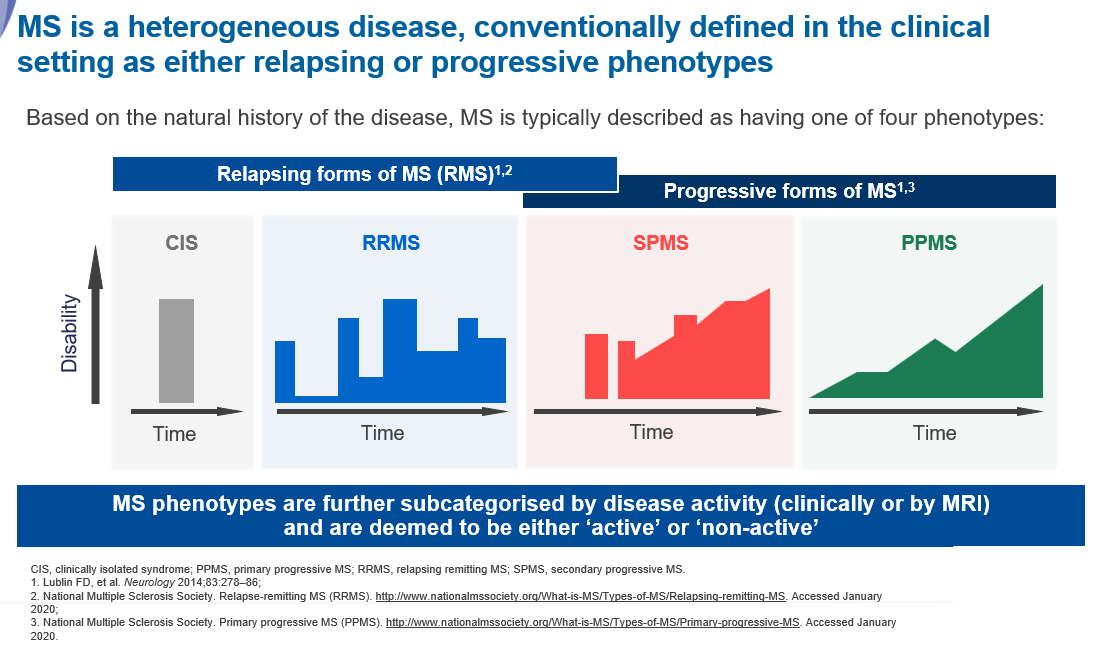

In [22]:
display.display(display.Image(base64.b64decode(relevant_images[0])))

In [12]:
result, relevant_images = answer("what is the treatment for relapcing onset ms with active phenotype")
print(result)

 Based on the context provided in the image, the treatment for relapsing-onset MS with an active phenotype typically involves the use of corticosteroids, intravenous immunoglobulins (IVIG), or plasmapheresis to manage acute relapses. Corticosteroids are a class of drugs that suppress the immune system and reduce inflammation. IVIG is a preparation of antibodies from human plasma, which can help to reduce the severity of symptoms. Plasmapheresis is a procedure in which blood components are removed and replaced with donated plasma. These treatments aim to manage the symptoms of an MS relapse and provide some degree of disease activity control. However, it's important to note that these treatments do not modify the underlying course of the disease. The decision to use any of these treatments depends on various factors, including the severity and frequency of relapses, the patient's overall health status, and other individual considerations.


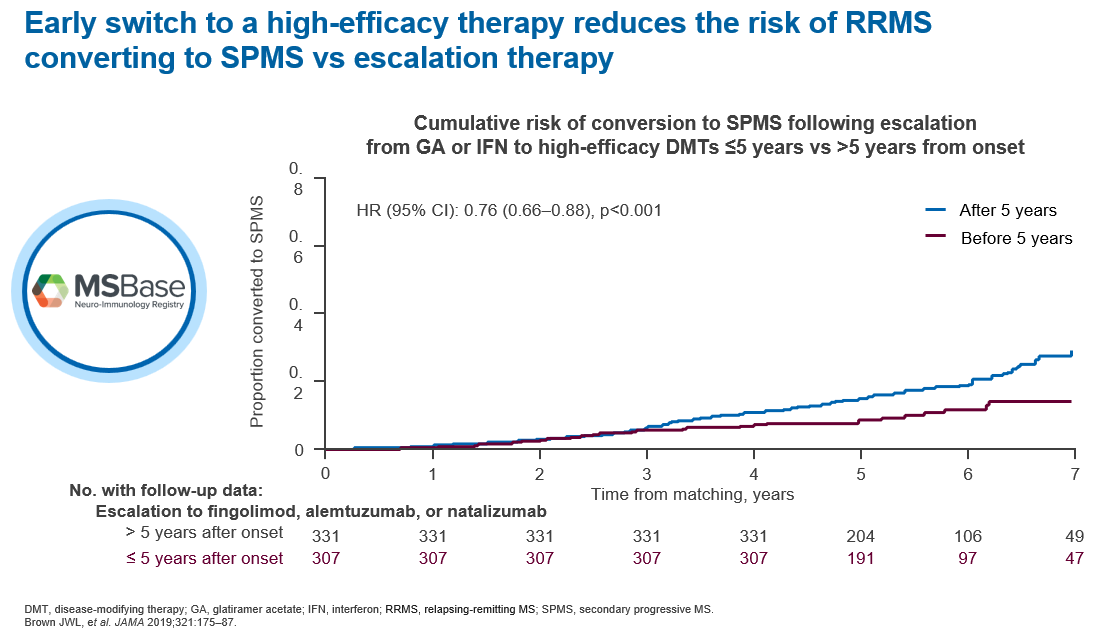

In [13]:
display.display(display.Image(base64.b64decode(relevant_images[0])))

In [35]:
result, relevant_images = answer("tell me the patient eligibility criteria for oratorio ")
print(result)

 Based on the context provided in the image, there is no clear indication of the specific patient eligibility criteria for the ORATORIO study or program. The image only shows a slide from a presentation about operational excellence methods in MS research, which includes inclusion and exclusion criteria for MS patients in general. There's no mention or connection to an ORATORIO study or its eligibility requirements. Therefore, I cannot provide a detailed answer regarding the patient eligibility criteria for ORATORIO.

Sorry, I don't have much information about it.


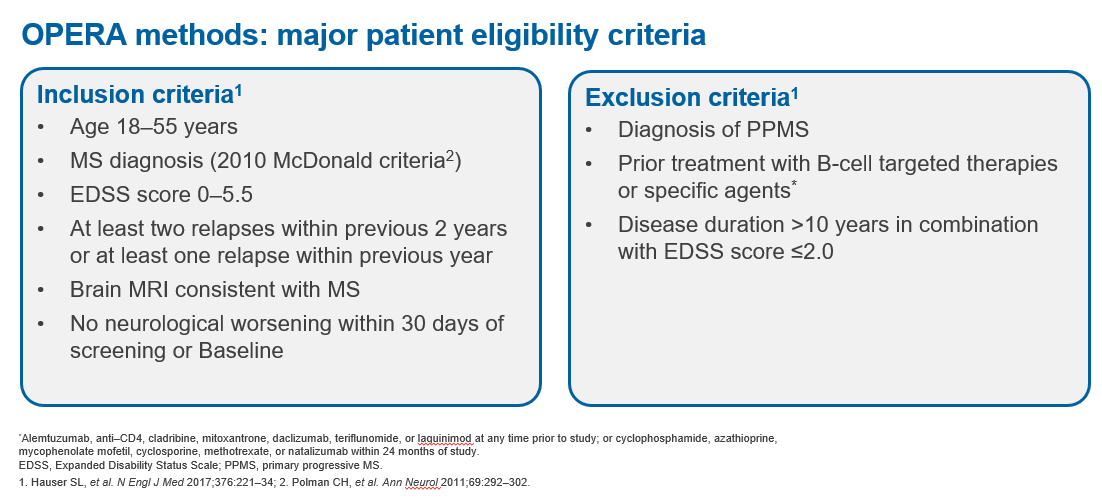

In [24]:
display.display(display.Image(base64.b64decode(relevant_images[0])))

In [15]:
result, relevant_images = answer("tell me the patient eligibility criteria for oratorio ")
print(result)

 Based on the context provided in the image, the ORATORIO clinical trial has specific eligibility criteria for participants. The inclusion criteria are:

1. Age and Gender: Participants must be aged 18-65 years old.
2. Essential Steering Committee (ESS) score of 0 or 1.
3. A confirmed diagnosis of relapsing remitting multiple sclerosis (RRMS) by a central review committee.
4. Previous disease-modifying treatment (DMT) is not required, but participants should have received one or more DMTs for at least 6 months and then discontinued.
5. Disease activity score of 0 or 1 according to the 2017 MSIS-SPONSE criteria.

There are exclusion criteria mentioned in the image as well, but they were not visible in the provided section. The study included a significant number of patients, with a total of 107 participants enrolled. For more detailed information about the study results and patient characteristics, please refer to the "RESULTS" section of the document.


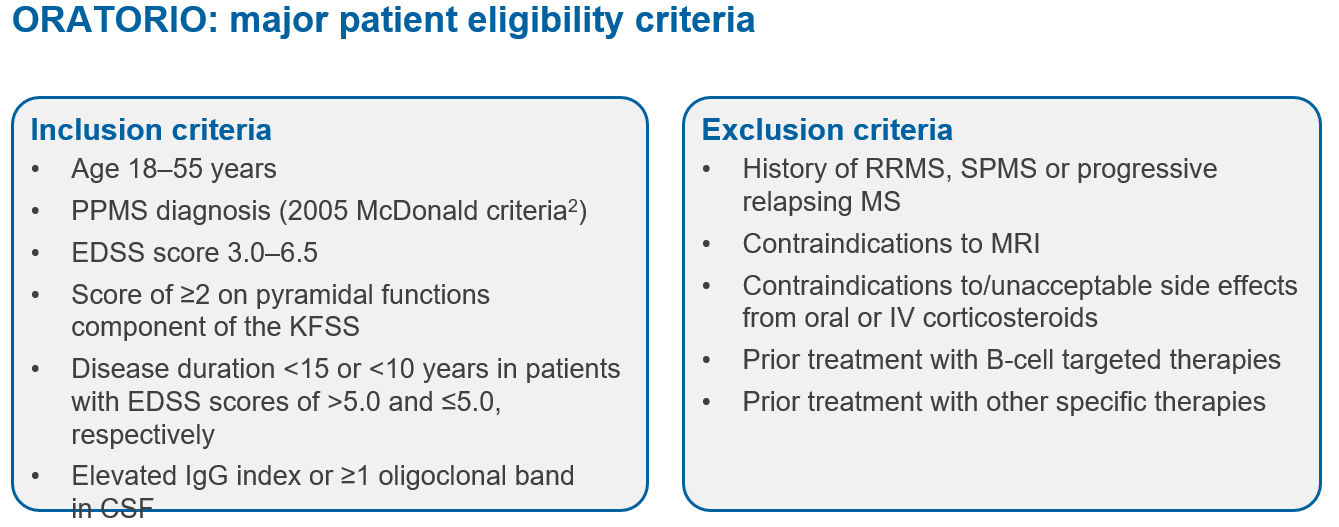

In [16]:
display.display(display.Image(base64.b64decode(relevant_images[0])))

In [17]:
result, relevant_images = answer("what is the role of mri")
print(result)

 The role of MRI (Magnetic Resonance Imaging) in multiple sclerosis is significant for diagnosis, monitoring disease progression, and early detection. The slide title "Role of MRI" indicates this topic. The main body of the slide contains three bullet points detailing these aspects:

1. **Diagnosis**: While the diagnosis of multiple sclerosis is based on history and physical findings, MRI plays a crucial role in confirming the diagnosis by detecting lesions (areas of damage) in the brain and spinal cord. However, diagnostic criteria for MS are not always definitive, leading to potential misdiagnoses or incorrect diagnoses.
2. **Monitoring disease progression**: MRI is used to monitor the progression of multiple sclerosis over time by detecting new lesions and changes in existing ones. This information helps healthcare professionals assess the effectiveness of treatments and adjust them accordingly.
3. **Early detection**: MRI can help in early detection of multiple sclerosis, especiall

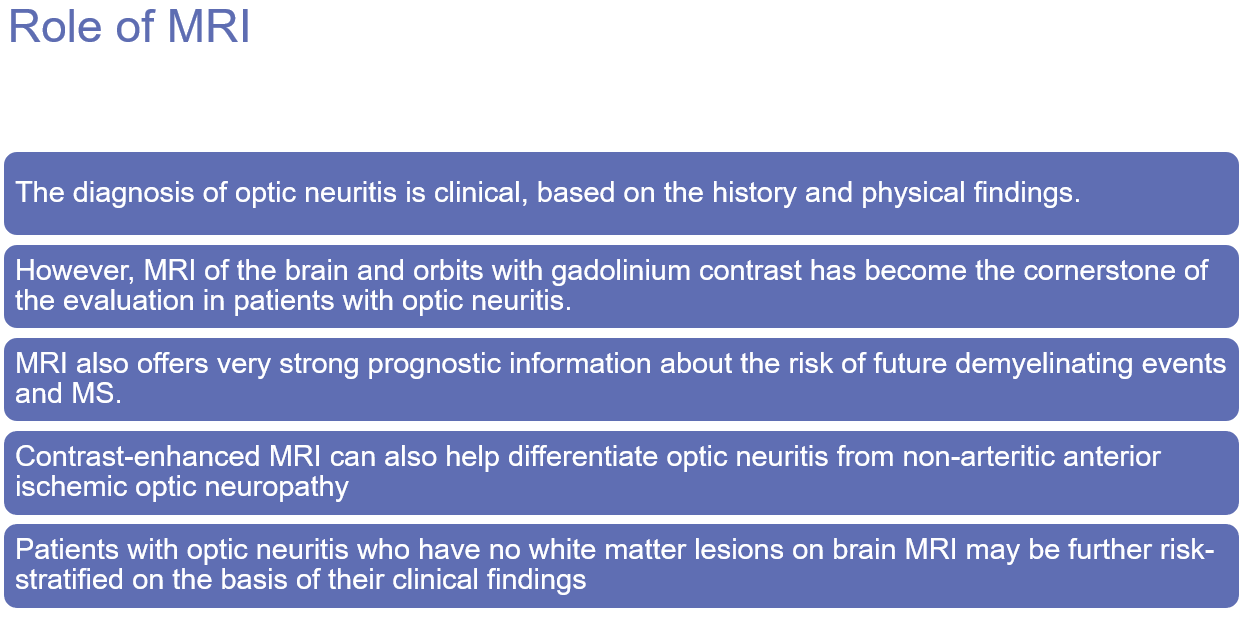

In [18]:
display.display(display.Image(base64.b64decode(relevant_images[0])))

In [19]:
result, relevant_images = answer("ocreves pivotal trial outcome opera I & II in RMS pooled analysis")
print(result)

 The pivotal trial for Ocrevus in relapsing-remitting multiple sclerosis (RMS) is referred to as the "OPERA I & II" study. This double-blind, placebo-controlled trial involved 300 participants and evaluated the efficacy and safety of Ocrevus (likely a drug called cremizumab). The primary outcome measure for this study was the Annualized Relapse Rate (ARR).

The flowchart in the image illustrates an analysis process, starting with the primary endpoint of ARR. It then proceeds to various statistical analyses, such as "Change in 2dDSS" and "Change in total volume of cerebrospinal fluid." The change in cerebrospinal fluid volume from baseline week 12 to baseline week 8 is shown to be 58% for one group and 71% for another.

The text beneath the flowchart provides additional information about the Ocrevus trial, specifically mentioning a change in total volume of cerebrospinal fluid from baseline at different time points. This suggests that the study might have assessed changes in the amount 

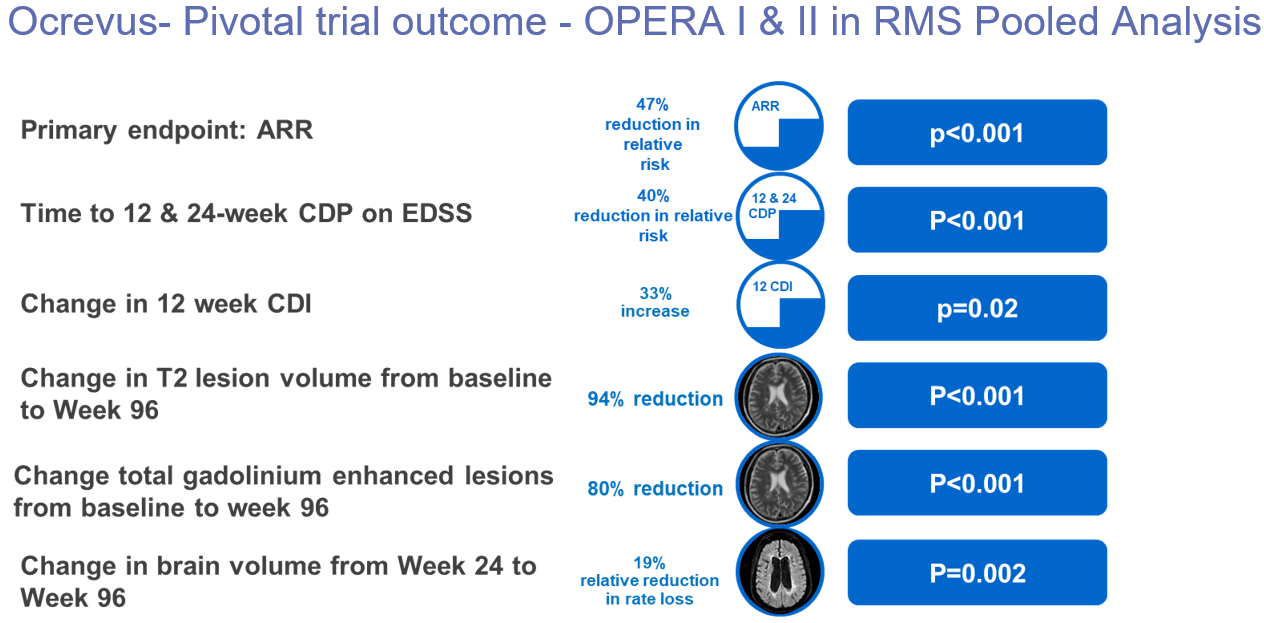

In [20]:
display.display(display.Image(base64.b64decode(relevant_images[0])))